First, we import the relevant libraries for the preprocessing section.

In [112]:
import os 
import pandas as pd
import numpy as np
import scipy.stats as scps
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

Reading in the data.

In [113]:
os.chdir('C:\\Users\ordav\Desktop\ML_Projects\HousePrices')
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

Getting some first impressions on the data

In [114]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Our target variable is 'SalePrice'. We will seperate it from the explenatory variables.
The Id is irrelevant as a feature, but we will need the test points' id's for the submissions.

In [115]:
train['SalePrice'] = np.log(1+train['SalePrice'])
y_train = train['SalePrice']
testId = test.Id
train.drop('Id', axis = 1, inplace=True)
test.drop('Id', axis = 1, inplace=True)


Looking at how nuch missing data we have. We will drop features with more than 20% missing entries.

In [116]:
n = len(train.index)
n

1460

In [117]:
m = len(test.index)
m

1459

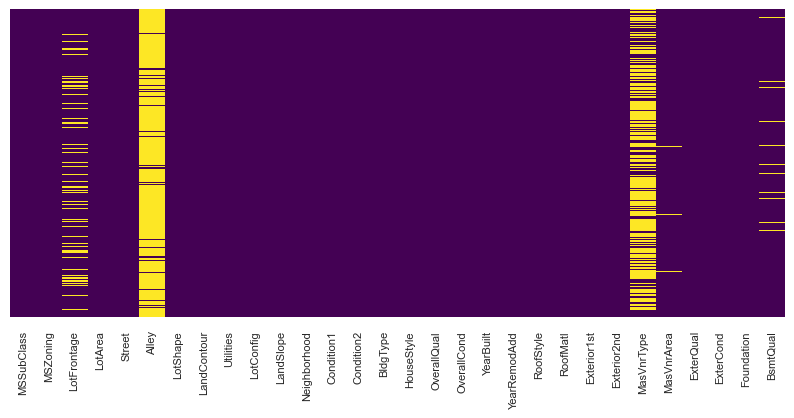

In [118]:
sns.set(rc={'figure.figsize':(10, 4)}) 
NAsHeatmap = sns.heatmap(train.iloc[:, :30].isnull(), cmap = 'viridis', cbar=False)
plt.xticks(rotation=90, fontsize=8)
NAsHeatmap.set(yticklabels = [])
NAsHeatmap.tick_params(left=False)

In [119]:
list(train.isna().sum()[train.isna().sum() > n * 0.2].sort_values().index)

['FireplaceQu', 'MasVnrType', 'Fence', 'Alley', 'MiscFeature', 'PoolQC']

In [120]:
list(test.isna().sum()[test.isna().sum() > m * 0.2].sort_values().index)

['FireplaceQu', 'MasVnrType', 'Fence', 'Alley', 'MiscFeature', 'PoolQC']

In [121]:
colsToDrop = list(train.isna().sum()[train.isna().sum() > n * 0.2].sort_values().index)
train.drop(colsToDrop, axis = 1, inplace=True)
test.drop(colsToDrop, axis = 1, inplace=True)

In [122]:
colsToDrop = ['TotalBsmtSF', 'TotRmsAbvGrd', 'GarageYrBlt', 'GarageCars']
train.drop(colsToDrop, axis = 1, inplace=True)
test.drop(colsToDrop, axis = 1, inplace=True)

In [123]:
list(train.isna().sum()[train.isna().sum() > 0].index)

['LotFrontage',
 'MasVnrArea',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Electrical',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond']

In [124]:
list(test.isna().sum()[test.isna().sum() > 0].index)

['MSZoning',
 'LotFrontage',
 'Utilities',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrArea',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinSF1',
 'BsmtFinType2',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'BsmtFullBath',
 'BsmtHalfBath',
 'KitchenQual',
 'Functional',
 'GarageType',
 'GarageFinish',
 'GarageArea',
 'GarageQual',
 'GarageCond',
 'SaleType']

We have a large amount of categorical variables, and a lot of them has a high number of categories. We want to create a function that will transform them to ordinal variables. 
Lets describe the algorithm:

1. Look at a categorical feature x.
2. Look at each category in it {z1, z2, ... , zk}
3. Seperate the 'SalePrice' by the category the observation belongs to. We have k numerical vectors.
4. We compare each 2 vectors using Wilcoxon's rank sum test, to check for a significant difference. Since we have  up to (k Choose 2) seperate null hypothesis, we need to make a Bonfferoni correction to our significance level to keep our FWER as 0.05. We do not want to be too conservative, so we will look at it like making k tests.
5. We now have s batches of categories. We consider each batch as equivalent (with respect to its effect on the target variable).
6. We choose a representative category from each batch and compute the mean of 'SalePrice' in the category.
7. We rank the batches by the mean we computed.
8. An observation's new ordinal feature is the rank of the batch where its category is located.

C:\Users\ordav\AppData\Local\Temp\ipykernel_1600\4052679108.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


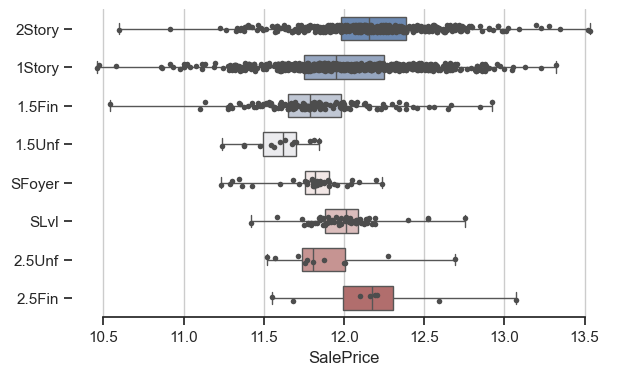

In [125]:
my_y = 'HouseStyle'

sns.set_theme(style="ticks")

# Initialize the figure with a logarithmic x axis
f, ax = plt.subplots(figsize=(7, 4))

# Plot the orbital period with horizontal boxes
sns.boxplot(
    train, y=my_y, x="SalePrice",
    whis=[0, 100], width=.6, palette="vlag"
)

# Add in points to show each observation
sns.stripplot(train, y=my_y, x="SalePrice", size=4, color=".3")

# Tweak the visual presentation
ax.xaxis.grid(True)
ax.set(ylabel="")
sns.despine(trim=True, left=True)

In [71]:
from operator import itemgetter

def batches(x, alpha):
    vals = train[x].dropna().unique()
    nUnique = len(vals)
    to_compare = {}
    for i in range(nUnique):
        to_compare[vals[i]] = train.loc[train[x] == vals[i], 'SalePrice']
    means_to_compare = {}
    for i in range(nUnique):
        means_to_compare[vals[i]] = np.mean(train.loc[train[x] == vals[i], 'SalePrice'])
    sorted_keys = sorted(means_to_compare, key=means_to_compare.get)
    batches = {1:[sorted_keys[0]]}
    curr_batch = 1
    appended = []
    for j in range(1, nUnique):
        prev = batches[curr_batch][0]
        new = sorted_keys[j]
        t = scps.ranksums(x = to_compare[prev], y = to_compare[new])
        p = t[1]
        if p >= alpha:
            batches[curr_batch].append(new)
        else:
            curr_batch = curr_batch + 1
            batches[curr_batch] = [new]
    #for j in to_compare.keys():
    #    if j not in appended:
    #        batches[j] = [j]
    #        appended.append(j)
    #        for k in to_compare.keys():
    #            if (k not in appended):
    #                t = scps.ranksums(x = to_compare[j], y = to_compare[k])
    #                p = t[1]
    #                if p >= (alpha / nUnique):
    #                    batches[j].append(k)
    #                    appended.append(k)
    return batches

def catToOrd(x, alpha):
    d = batches(x, alpha)
    train_new = pd.Series(0, index=np.arange(len(train.index)))
    test_new = pd.Series(0, index=np.arange(len(test.index)))
    for i in range(len(train.index)):
        if pd.isna(train[x][i]):
            train_new[i] = np.nan
        else:
            for j in d.keys():
                if train[x][i] in d[j]:
                    train_new[i] = j
    for i in range(len(test.index)):
        if pd.isna(test[x][i]):
            test_new[i] = np.nan
        else:
            for j in d.keys():
                if test[x][i] in d[j]:
                    test_new[i] = j
            
    return [train_new, test_new]

def catToOrdDF(alpha):
    colsToDrop = []
    types = train.dtypes
    for j in range(len(types)):
        if types.iloc[j] == object:
            x = train.columns[j]
            ordx = catToOrd(x, alpha)
            train['New'+x] = ordx[0]
            test['New'+x] = ordx[1]
            colsToDrop.append(x)
    train.drop(colsToDrop, axis = 1, inplace = True)
    test.drop(colsToDrop, axis = 1, inplace = True)

In [72]:
catToOrdDF(0.05)

We notice that the 'MSSubClass' feature is also categorical, although it encoded with numerical values.

In [73]:
newCols = catToOrd('MSSubClass', 0.05)

In [74]:
train.MSSubClass = newCols[0]
test.MSSubClass = newCols[1]

In [75]:
train['NewHouseStyle'] = train['NewHouseStyle'].astype("category")

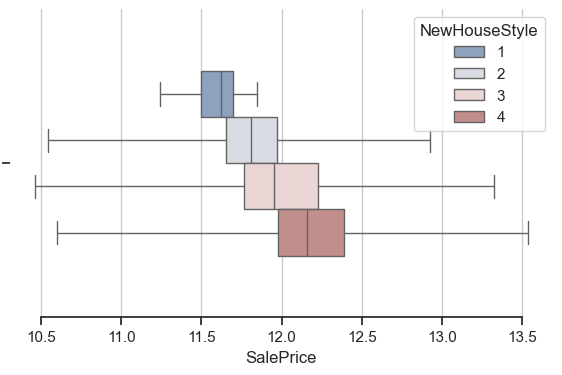

In [76]:
my_y = 'NewHouseStyle'

sns.set_theme(style="ticks")

# Initialize the figure with a logarithmic x axis
f, ax = plt.subplots(figsize=(7, 4))

# Plot the orbital period with horizontal boxes
sns.boxplot(
    train, hue=my_y, x="SalePrice",
    whis=[0, 100], width=.6, palette="vlag"
)

# Add in points to show each observation
#sns.stripplot(train, y=my_y, x="SalePrice", size=4, color=".3")

# Tweak the visual presentation
ax.xaxis.grid(True)
ax.set(ylabel="")
sns.despine(trim=True, left=True)

In [77]:
train['NewLotShape'] = train['NewLotShape'].astype("category")

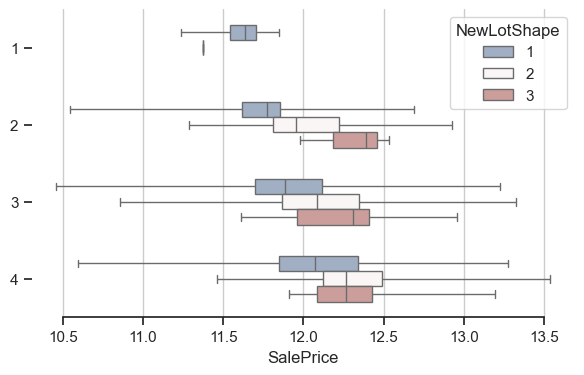

In [78]:
my_y = 'NewHouseStyle'

sns.set_theme(style="ticks")

# Initialize the figure with a logarithmic x axis
f, ax = plt.subplots(figsize=(7, 4))

# Plot the orbital period with horizontal boxes
sns.boxplot(
    train, y=my_y, x="SalePrice", hue = "NewLotShape",
    whis=[0, 100], width=.6, palette="vlag"
)

# Add in points to show each observation
#sns.stripplot(train, y=my_y, x="SalePrice", size=4, color=".3")

# Tweak the visual presentation
ax.xaxis.grid(True)
ax.set(ylabel="")
sns.despine(trim=True, left=True)

In [79]:
train['NewLotShape'] = train['NewLotShape'].astype(int)
train['NewHouseStyle'] = train['NewHouseStyle'].astype(int)

We can now drop the 'SalePrice' column from the training set.

In [80]:
train.drop('SalePrice', axis = 1, inplace = True)

We need to remember that our process might produce features that are constant .We check for features like that. 

In [81]:
sum(train.std() == 0)

9

We drop these columns.

In [82]:
boolConst = (train.std() == 0)
colsToDrop = boolConst.index[boolConst]
train.drop(colsToDrop, axis = 1, inplace=True)
test.drop(colsToDrop, axis = 1, inplace=True)

We want to avoid high correlation between features. We check which of them has a high linear correlation using Pearson's Correlation Coefficient, and drop ones who are closely realated to others. We drop the ones with a smaller Pearson's Correlation Coefficient to the target variable.

In [83]:
def dropCorrs(alpha):
    corrs = train.corr()
    corrCols = []
    appearences = []
    for i in range(len(corrs.index) - 1):
        for j in range(i):
            if abs(corrs).iloc[i,j] > alpha:
                corrCols.append([corrs.columns[i], corrs.columns[j]])
    colsToDrop = []
    for k in corrCols:
        if (k[0] not in colsToDrop) and (k[1] not in colsToDrop):
            p0 = y_train.corr(train[k[0]])
            p1 = y_train.corr(train[k[1]])
            if p0 > p1:
                colsToDrop.append(k[1])
            else:
                colsToDrop.append(k[0])
    return(colsToDrop)

[Text(0.5, 96.74999999999997, ''), Text(54.74999999999999, 0.5, '')]

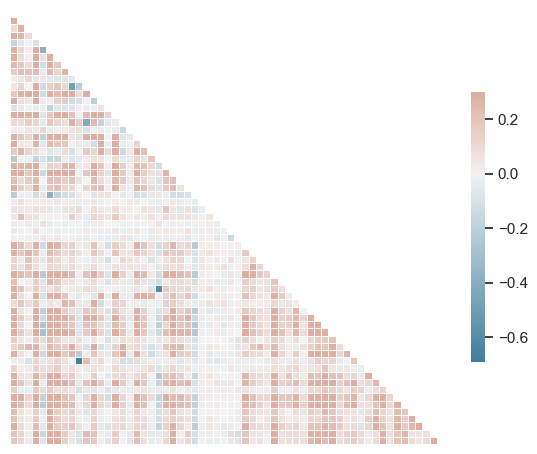

In [84]:
sns.set_theme(style="white")

# Compute the correlation matrix
corr = train.iloc[:, :].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(7, 7))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
ax = sns.heatmap(corr, mask = mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

ax.set_xticks([])  # Remove x-axis ticks
ax.set_yticks([])  # Remove y-axis ticks
ax.set(xlabel=None, ylabel=None)

In [85]:
len(train.columns)

60

In [86]:
colsDrop = dropCorrs(0.7)
train.drop(colsDrop, axis = 1, inplace = True)
test.drop(colsDrop, axis = 1, inplace = True)

In [87]:
len(train.columns)

58

We are measured using the RMSE between the log of the predictions and the log of the real values, and therefore we will use the log of 'SalePrice' for training.

We fill the missing data using Iterative Imputer, an imputation method that uses the other features and a regression model to fill in the missing entries.

In [88]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

imputer = IterativeImputer(max_iter=100)
train = pd.DataFrame(imputer.fit_transform(train), columns=train.columns)
test = pd.DataFrame(imputer.transform(test), columns=test.columns)

Scaling the data.

In [89]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train = pd.DataFrame(scaler.fit_transform(train), columns=train.columns)
test = pd.DataFrame(scaler.transform(test), columns=test.columns)

We can now start and train some models. Tuning their parameters will be done using 5-fold CV.

We first try to fit lasso to the data. We will also use this as feature selection method for different methods.

In [90]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge

paramGrid = {'alpha' : [i for i in range(1,400)]}
ridge = Ridge(max_iter = 1000)
gridSearch = GridSearchCV(estimator=ridge, param_grid=paramGrid)
g = gridSearch.fit(train, y_train)
bestAlphaRidge = g.best_params_['alpha']
print('Optimal alpha value: ' + str(bestAlphaRidge))

Optimal alpha value: 182


The error on the train set

In [91]:
ridge = Ridge(alpha = bestAlphaRidge)
ridge.fit(train, y_train)
y_pred = ridge.predict(train)
rmse = np.sqrt(np.mean((y_pred - y_train) ** 2))
rmse

0.12988455149145725

Create prediction on the test set

In [92]:
ridge = Ridge(alpha = bestAlphaRidge)
ridge.fit(train, y_train)
y_pred = ridge.predict(test)
y_pred = np.exp(y_pred) - 1
y_pred = pd.DataFrame({'Id' : testId, 'SalePrice' : y_pred})
y_pred.to_csv('HousePricePredictionsRidge.csv', index = False)

We got a score of 0.1345. Lets see if we can improve. 
<br>
We will try and use a random forest.
We need to tune the number of trees, the level of pruning and the number of features we choose from at each split.

In [93]:
from sklearn.ensemble import RandomForestRegressor

paramGrid = {'n_estimators' : [200, 250, 300], 'ccp_alpha' : [0.001 * i for i in range(4)],
            'max_features' : [0.2, 0.25, 0.3]}
rFor = RandomForestRegressor()
gridSearch = GridSearchCV(estimator=rFor, param_grid=paramGrid)
g = gridSearch.fit(train, y_train)
bestAlphaRandFor = g.best_params_['ccp_alpha']
bestNumTreesRandFor = g.best_params_['n_estimators']
bestMaxFeat = g.best_params_['max_features']
print('Optimal ccp_alpha value: ' + str(bestAlphaRandFor) + '\n' +
     'Optimal number of trees: ' + str(bestNumTreesRandFor) + '\n' +
     'Optimal number of features in each split: ' + str(bestMaxFeat))

Optimal ccp_alpha value: 0.0
Optimal number of trees: 250
Optimal number of features in each split: 0.3


Lets Check the error on the train set

In [94]:
rFor = RandomForestRegressor(n_estimators = bestNumTreesRandFor,
                             ccp_alpha = bestAlphaRandFor,
                            max_features = bestMaxFeat)
rFor.fit(train, y_train)
y_pred = rFor.predict(train)
rmse = np.sqrt(np.mean((y_pred - y_train) ** 2))
rmse

0.0490526957978358

Create the predictionn for the test set

In [95]:
rFor = RandomForestRegressor(n_estimators = bestNumTreesRandFor,
                             ccp_alpha = bestAlphaRandFor,
                            max_features = bestMaxFeat)
rFor.fit(train, y_train)
y_pred = rFor.predict(test)
y_pred = np.exp(y_pred) - 1
y_pred = pd.DataFrame({'Id' : testId, 'SalePrice' : y_pred})
y_pred.to_csv('HousePricePredictionsRandomForest.csv', index = False)

We got a score of 0.138.
This is small decrease in preformence than we got using Ridge. It implies that the linear model is not a bad idea. The random forest seems to over fit.
<br>
Therefore, next we try and use a Support Vector Regressor with a linear kernel.
<br>
We need to try and find the optimal epsilon (allowed error) and C (inverse regularization coefficient).

In [96]:
from sklearn.svm import SVR
linearSvr = SVR(kernel = 'linear')
paramGrid = {'C' : [0.001 * i for i in range(1, 10)], 'epsilon' : [0.01 * i for i in range(6, 10)]}
gridSearch = GridSearchCV(estimator=linearSvr, param_grid=paramGrid)
g = gridSearch.fit(train, y_train)
bestC = g.best_params_['C']
bestEps = g.best_params_['epsilon']
print('Optimal C value: ' + str(bestC) + '\n' +
     'Optimal epsilon value: ' + str(bestEps))

Optimal C value: 0.001
Optimal epsilon value: 0.07


The error in the train set:

In [97]:
linearSvr = SVR(kernel = 'linear', C=bestC, epsilon = bestEps)
linearSvr.fit(train, y_train)
y_pred = linearSvr.predict(train)
rmse = np.sqrt(np.mean((y_pred - y_train) ** 2))
rmse

0.13649611380213048

Predicting on the test set

In [98]:
linearSvr = SVR(kernel = 'linear', C=bestC, epsilon = bestEps)
linearSvr.fit(train, y_train)
y_pred = linearSvr.predict(test)
y_pred = np.exp(y_pred) - 1
y_pred = pd.DataFrame({'Id' : testId, 'SalePrice' : y_pred})
y_pred.to_csv('HousePricePredictionsLinearSVR.csv', index = False)

We got a score of 0.1354.
<br>
We will go back to a tree based methods, specifically XGBoost.
<br>
We will adjust the learning rate and the lambda & alpha regularization parameters (l2 & l1).

In [99]:
import xgboost as xgb
from sklearn.model_selection import train_test_split

xgb1 = xgb.XGBRegressor(n_estimators = 500, max_depth = 4)
paramGrid = {'learning_rate' : [0.01 * i for i in range(1, 5)],
            'reg_alpha' : [0.001 * i for i in range(1, 5)], 'reg_lambda' : [0.00001 * i for i in range(1, 5)]}
gridSearch = GridSearchCV(estimator=xgb1, param_grid=paramGrid)
g = gridSearch.fit(train, y_train)
bestLearningRate = g.best_params_['learning_rate']
bestLambda = g.best_params_['reg_lambda']
bestAlphaXGB = g.best_params_['reg_alpha']
print('Optimal learning rate: ' + str(bestLearningRate) + '\n' +
     'Optimal lambda: ' + str(bestLambda) + '\n' +
     'Optimal alpha: ' + str(bestAlphaXGB))

Optimal learning rate: 0.03
Optimal lambda: 4e-05
Optimal alpha: 0.003


In order to avoid overfitting we will add an early stopping criteria. If we had not made an improvement in the last 10 steps, we will stop the training and return only the ensemble we have built upn to that point.

Error on the train set

In [100]:
from sklearn.model_selection import train_test_split
xgb1 = xgb.XGBRegressor(n_estimators = 500, max_depth = 4, 
                          learning_rate = bestLearningRate,
                         reg_lambda = bestLambda,
                          reg_alpha = bestAlphaXGB, early_stopping_rounds = 10)

X_train_1, X_val, y_train_1, y_val = train_test_split(train, y_train, test_size = 0.1)
xgb1.fit(X_train_1, y_train_1, eval_set = [(X_val, y_val)], verbose = 0)
y_pred = xgb1.predict(train)
rmse = np.sqrt(np.mean((y_pred - y_train) ** 2))
rmse

0.06243770980996645

Predictions for the test set

In [101]:
xgb1 = xgb.XGBRegressor(n_estimators = 500, max_depth = 4, 
                          learning_rate = bestLearningRate,
                         reg_lambda = bestLambda,
                          reg_alpha = bestAlphaXGB, early_stopping_rounds = 10)

X_train_1, X_val, y_train_1, y_val = train_test_split(train, y_train, test_size = 0.1)
xgb1.fit(X_train_1, y_train_1, eval_set = [(X_val, y_val)], verbose = 0)
y_pred = xgb1.predict(test)
y_pred = np.exp(y_pred) - 1
y_pred = pd.DataFrame({'Id' : testId, 'SalePrice' : y_pred})
y_pred.to_csv('HousePricePredictionsXGB.csv', index = False)

We got a great improvement to our best score with 0.13031.

Now we will try a new approach. We will combine all of the prior models into one using exponential weighting. This process is supposed to reduce prediction variance (and therefore avoid overfitting) with a slight increase in bias (compared to the best model).

First, we need to train the model on a subset of the training data. We will use a random subset of 90%.
The rest of the data will be used in order to determine the weights.

In [102]:
X_train, X_weights, y_train, y_weights = train_test_split(train, y_train, test_size = 0.1)

In [103]:
ridge = Ridge(alpha = bestAlphaRidge, max_iter = 1000)
ridge.fit(X_train, y_train)
y_pred = ridge.predict(X_weights)
e1 = np.exp(-np.sum((y_pred - y_weights) ** 2))

In [104]:
rFor = RandomForestRegressor(n_estimators = bestNumTreesRandFor, 
                             max_features = bestMaxFeat, ccp_alpha=bestAlphaRandFor)
rFor.fit(X_train, y_train)
y_pred = rFor.predict(X_weights)
e2 = np.exp(-np.sum((y_pred - y_weights) ** 2))

In [105]:
linearSvr = SVR(kernel = 'linear', C = bestC, epsilon = bestEps)
linearSvr.fit(X_train, y_train)
y_pred = linearSvr.predict(X_weights)
e3 = np.exp(-np.sum((y_pred - y_weights) ** 2))

In [106]:
xgb1 = xgb.XGBRegressor(n_estimators = 500, max_depth = 4, 
                          learning_rate = bestLearningRate,
                         reg_lambda = bestLambda,
                          reg_alpha = bestAlphaXGB, early_stopping_rounds = 10)

X_train_2, X_val_1, y_train_2, y_val_1 = train_test_split(X_train, y_train, test_size = 0.1)
xgb1.fit(X_train_2, y_train_2, eval_set = [(X_val_1, y_val_1)], verbose = 0)
y_pred = xgb1.predict(X_weights)
e4 = np.exp(-np.sum((y_pred - y_weights) ** 2))

In [107]:
den = e1 + e2 + e3 +  e4
w1 = e1/den
w2 = e2/den
w3 = e3/den
w4 = e4/den

In [108]:
print(e1, e2, e3, e4)
print(w1, w2, w3, w4)

0.0956019204472143 0.07820826856815938 0.12201992891373821 0.10928867874300163
0.2359849042615284 0.1930502094956061 0.30119542691201295 0.2697694593308525


In [109]:
y_pred_ridge = ridge.predict(test)
y_pred_rFor = rFor.predict(test)
y_pred_svr = linearSvr.predict(test)
y_pred_xgb = xgb1.predict(test)

y_pred = w1 * y_pred_ridge + w2 * y_pred_rFor +  w3 * y_pred_svr + w4 * y_pred_xgb
y_pred = np.exp(y_pred) - 1
y_pred = pd.DataFrame({'Id' : testId, 'SalePrice' : y_pred})
y_pred.to_csv('HousePricePredictionsAggregation.csv', index = False)

We indeed manage to get a better result than all the other models: 0.12638!

In [110]:
y_pred_ridge = ridge.predict(train)
y_pred_rFor = rFor.predict(train)
y_pred_svr = linearSvr.predict(train)
y_pred_xgb = xgb1.predict(train)

y_pred = w1 * y_pred_ridge + w2 * y_pred_rFor +  w3 * y_pred_svr + w4 * y_pred_xgb